In [6]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import PassManager

service = QiskitRuntimeService()



In [7]:
backend1 = service.backend("ibm_sherbrooke") 
target = backend1.target
basis_gates = list(target.operation_names)

In [8]:
def get_ghz_circ_static(num_qubit):
    if num_qubit%2==1:                                                     #odd no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-1)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-1):
            qc.cx(i,i+1)
            qc.cx(num_qubit-i-1,num_qubit-i-2)
        

    else:                                                                    #even no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-2)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-2):
            qc.cx(i,i+1)
            qc.cx(num_qubit-1-i-1,num_qubit-i-3)
        qc.cx(num_qubit-2,num_qubit-1)
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    return qc

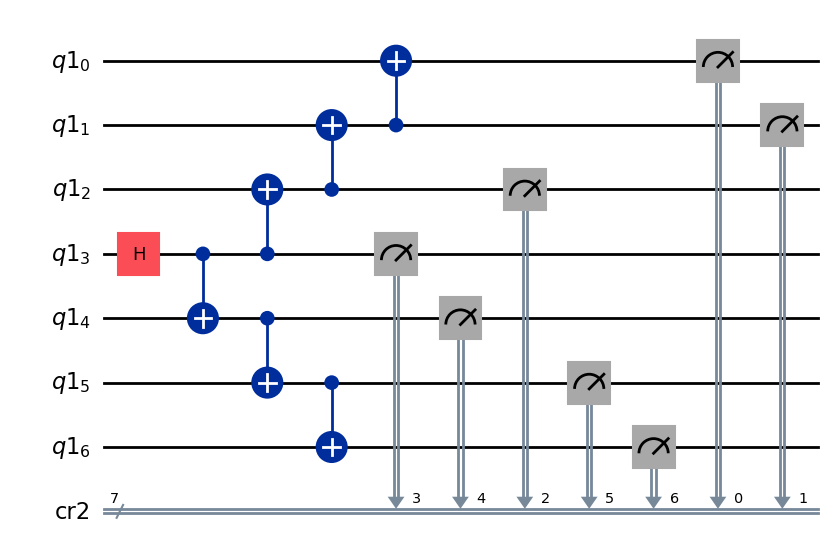

In [4]:
qc = get_ghz_circ_static(num_qubit=7)
qc.draw("mpl")

In [5]:
#dynamic circuit using qubit-reuse in aersimulator

In [9]:
def get_ghz_circ_static_1(num_qubit):
    if num_qubit%2==1:                                                     #odd no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-1)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-1):
            qc.cx(i,i+1)
            qc.cx(num_qubit-i-1,num_qubit-i-2)
        

    else:                                                                    #even no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-2)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-2):
            qc.cx(i,i+1)
            qc.cx(num_qubit-1-i-1,num_qubit-i-3)
        qc.cx(num_qubit-2,num_qubit-1)
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    return qc

In [10]:
#creating dynamic circuit from a separate static circuit
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

def get_ghz_circ_dynamic_2(num_qubit):
    qc=get_ghz_circ_static_1(num_qubit)
    aer_sim = AerSimulator()
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1, init_method="qubit_reuse")
    transpiled_qc = pm.run(qc)
    
    return transpiled_qc

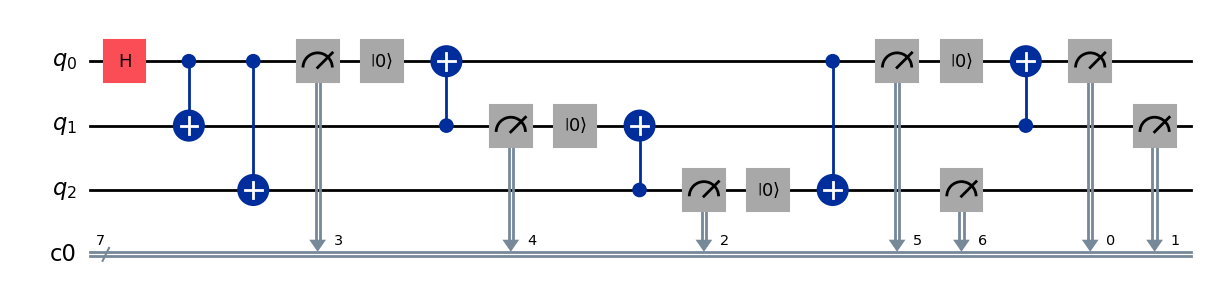

In [7]:
qc = get_ghz_circ_dynamic_2(num_qubit=7)
qc.draw("mpl")

In [85]:
#Creating list of circuits[Static_1, Dynamic1_1, Dynamic2_1, Static_1, Dynamic1_1, Dynamic2_1,...,Static_2, Dynamic1_2, Dynamic2_2, Static_2, Dynamic1_2, Dynamic2_2,...] i.e. some copies of each of them
from qiskit import qasm2
min_qubit=17
max_num_qubit=21
copies=4

#qc_list_dynamic_1=[]
#qc_list_dynamic_2=[]
#qc_list_static=[]
#observables=[]

qc_list=[]
qasm_static_circuit_list=[]
qasm_qubit_reuse_circuit_list=[]
transpiled_static_num_qubits_list=[]
transpiled_qubit_reuse_num_qubits_list=[]
qc_depth_static_list=[]
qc_depth_qubit_reuse_list=[]

num_qubit_list=list(range(min_qubit,max_num_qubit+1,2))
for num_qubit in num_qubit_list:
    qasm_static_circuit_list.append(qasm2.dumps(get_ghz_circ_static(num_qubit)))
    qasm_qubit_reuse_circuit_list.append(qasm2.dumps(get_ghz_circ_dynamic_2(num_qubit)))
    transpiled_static_num_qubits_list.append(get_ghz_circ_static(num_qubit).num_qubits)
    transpiled_qubit_reuse_num_qubits_list.append(get_ghz_circ_dynamic_2(num_qubit).num_qubits)
    qc_depth_static_list.append(get_ghz_circ_static(num_qubit).depth())
    qc_depth_qubit_reuse_list.append(get_ghz_circ_dynamic_2(num_qubit).depth())
    for i in range(copies):
        qc_list.append(get_ghz_circ_static(num_qubit))
        #qc_list.append(get_ghz_circ_dynamic_1(num_qubit))
        qc_list.append(get_ghz_circ_dynamic_2(num_qubit))
print(num_qubit_list)

[17, 19, 21]


In [12]:
#Ideal Simulation with AerSimulator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=2,basis_gates=basis_gates)
qc_transpiled_list=[]

qc_transpiled_list_ideal = pm.run(qc_list)

In [55]:
transpiled_num_qubits_list=[qc.num_qubits for qc in qc_transpiled_list_ideal]

In [13]:
sampler = Sampler(backend=aer_sim)
result_ideal = sampler.run(qc_transpiled_list_ideal).result()

In [14]:
print(result_ideal)
len(result_ideal)

PrimitiveResult([PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(c0=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(c4=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(c6=BitArray(<shape=(), num_shots=1024, num_bits=17>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=19>))), PubResult(data=DataBin(c8=BitArray(<shape=(), num_shots=1024, num_bits=19>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=19>))), PubResult(data=DataBin(c10=BitArray(<shape=(), num_shots=1024, num_bits=19>))), PubResult(data=DataBin(cr2=B

24

In [23]:
# For getting list of ideal counts (argument required for Fidelity)
counts_list_ideal=[]
k=0
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static = result_ideal[(2*i*copies)+(2*j)].data    
        #data_dynamic_1 = result_ideal[(3*i*copies)+((3*j)+1)].data 
        data_dynamic_2 = result_ideal[(2*i*copies)+((2*j)+1)].data

        print(data_static)
        #print(data_dynamic_1)
        print(data_dynamic_2)
        
        counts_static=data_static.cr2.get_counts()
        #counts_dynamic_1=data_dynamic_1.cr2.get_counts()
        
        # Replacing 'cr2' with the appropriate attribute if needed
        dynamic_2_attr_name = f'c{2*(k)}'
        if hasattr(data_dynamic_2, dynamic_2_attr_name):
            counts_dynamic_2 = getattr(data_dynamic_2, dynamic_2_attr_name).get_counts()
        else:
            raise AttributeError(f"{dynamic_2_attr_name} not found in data_dynamic_2")
        
        counts_list_ideal.append(counts_static)
        #counts_list_ideal.append(counts_dynamic_1)
        counts_list_ideal.append(counts_dynamic_2)
        k=k+1

DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(c0=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(c4=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(c6=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(c8=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(c10=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(c12=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(c14=BitArray(<shape=(), num_shots=1024, num_bits=19>

In [15]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

 
# Save an IBM Quantum account and set it as your default account.

 
# Load saved credentials
service = QiskitRuntimeService()
backend_name = "ibm_sherbrooke"
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)
pm = generate_preset_pass_manager(optimization_level=2, backend=backend, basis_gates=basis_gates)
qc_transpiled_list = pm.run(qc_list)

In [35]:
#Executing the circuit
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)

from qiskit_ibm_runtime import Options

options = sampler.options
 
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = 'XY4'

In [13]:
#Executing the circuit
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)

from qiskit_ibm_runtime import Options

options = sampler.options
 
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = 'XY4'
#dynamical_decoupling={'enable':True, 'sequence_type':'XpXm'}
job = sampler.run(qc_transpiled_list,shots=1024)
print(job.job_id())

ctmx6gj4gjh0008peqm0


In [33]:
#post processing
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)

#from qiskit_ibm_runtime import Options
 
# Estimator and Sampler now have different options
options = sampler.options

In [16]:
#Post-processing
import matplotlib.pyplot as plt
import statistics
from qiskit_ibm_runtime import QiskitRuntimeService

job_id = 'ctmx6gj4gjh0008peqm0' #Sherbrooke

service = QiskitRuntimeService()
job = service.job(job_id)
result_real = job.result()

In [17]:
print(result_real)
len(result_real)

PrimitiveResult([PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(c0=BitArray(<shape=(), num_shots=1024, num_bits=17>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=17>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(c4=BitArray(<shape=(), num_shots=1024, num_bits=17>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(c6=BitArray(<shape=(), num_shots=1024, num_bits=17>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_

24

In [18]:
#Finding the metrics of the job
result_metric_real=job.metrics()
print(result_metric_real)

{'timestamps': {'created': '2024-07-31T06:01:38.725587Z', 'finished': '2024-08-01T01:58:16.834Z', 'running': '2024-08-01T01:54:44.131Z'}, 'bss': {'seconds': 104}, 'usage': {'quantum_seconds': 104, 'seconds': 104}, 'executions': 24576, 'num_circuits': 24, 'num_qubits': [127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127], 'circuit_depths': [75, 350, 67, 350, 75, 349, 67, 350, 78, 396, 69, 396, 78, 396, 76, 396, 76, 444, 75, 443, 70, 444, 76, 443], 'qiskit_version': 'qiskit_ibm_runtime-0.23.0,qiskit-1.1.0*,qiskit_aer-0.14.2*,qiskit_experiments-0.6.1,circuit_knitting_toolbox-0.7.2', 'estimated_start_time': '2024-08-01T01:54:21.924Z', 'estimated_completion_time': '2024-08-01T01:56:05.797Z', 'caller': 'qiskit_ibm_runtime~sampler.py'}


In [19]:
# For getting list of real counts of IBM brisbane (argument required for Fidelity)
counts_list_real=[]
k=0
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static = result_real[(2*i*copies)+(2*j)].data    
        #data_dynamic_1 = result_real[(3*i*copies)+((3*j)+1)].data 
        data_dynamic_2 = result_real[(2*i*copies)+((2*j)+1)].data

        print(data_static)
        #print(data_dynamic_1)
        print(data_dynamic_2)
        
        counts_static=data_static.cr2.get_counts()
        #counts_dynamic_1=data_dynamic_1.cr2.get_counts()
        
        # Replacing 'cr3' with the appropriate attribute if needed
        dynamic_2_attr_name = f'c{2*(k)}'
        if hasattr(data_dynamic_2, dynamic_2_attr_name):
            counts_dynamic_2 = getattr(data_dynamic_2, dynamic_2_attr_name).get_counts()
        else:
            raise AttributeError(f"{dynamic_2_attr_name} not found in data_dynamic_2")
        
        counts_list_real.append(counts_static)
        #counts_list_real.append(counts_dynamic_1)
        counts_list_real.append(counts_dynamic_2)
        k=k+1

DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(c0=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(c4=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(c6=BitArray(<shape=(), num_shots=1024, num_bits=17>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(c8=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(c10=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(c12=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=19>))
DataBin(c14=BitArray(<shape=(), num_shots=1024, num_bits=19>

In [24]:
#Calculation of lists of Fidelity mean and std deviation of real hardware simulation in ibm_sherbrooke
import statistics
from qiskit.quantum_info.analysis import hellinger_fidelity
# We will create 4 lists of Fidelities, for storing mean, std deviation of Fidelity, of copies of a circuit for fixed no of logical qubits
 
Fidelity_mean_static_sherbrooke=[]
#Fidelity_mean_dynamic_1_sherbrooke=[]
Fidelity_mean_dynamic_2_sherbrooke=[]

Fidelity_std_static_sherbrooke=[]
#Fidelity_std_dynamic_1_sherbrooke=[]
Fidelity_std_dynamic_2_sherbrooke=[]

Fidelity_copies_static_sherbrooke=[]
#Fidelity_copies_dynamic_1_sherbrooke=[]
Fidelity_copies_dynamic_2_sherbrooke=[]

for i in range(len(num_qubit_list)):
    
    for j in range(copies):
        
        Fidelity_static= hellinger_fidelity(counts_list_ideal[(2*i*copies)+(2*j)], counts_list_real[(2*i*copies)+(2*j)])
        #Fidelity_dynamic_1=hellinger_fidelity(counts_list_ideal[(3*i*copies)+((3*j)+1)], counts_list_real[(3*i*copies)+((3*j)+1)])
        Fidelity_dynamic_2=hellinger_fidelity(counts_list_ideal[(2*i*copies)+((2*j)+1)], counts_list_real[(2*i*copies)+((2*j)+1)])
        
        Fidelity_copies_static_sherbrooke.append(Fidelity_static)
        #Fidelity_copies_dynamic_1_sherbrooke.append(Fidelity_dynamic_1)
        Fidelity_copies_dynamic_2_sherbrooke.append(Fidelity_dynamic_2)

    
    Fidelity_mean_static_sherbrooke.append(statistics.mean(Fidelity_copies_static_sherbrooke))
    #Fidelity_mean_dynamic_1_sherbrooke.append(statistics.mean(Fidelity_copies_dynamic_1_sherbrooke))
    Fidelity_mean_dynamic_2_sherbrooke.append(statistics.mean(Fidelity_copies_dynamic_2_sherbrooke))
    
    Fidelity_std_static_sherbrooke.append(statistics.stdev(Fidelity_copies_static_sherbrooke))
    #Fidelity_std_dynamic_1_sherbrooke.append(statistics.stdev(Fidelity_copies_dynamic_1_sherbrooke))
    Fidelity_std_dynamic_2_sherbrooke.append(statistics.stdev(Fidelity_copies_dynamic_2_sherbrooke))
    
    Fidelity_copies_static_sherbrooke.clear()
    #Fidelity_copies_dynamic_1_sherbrooke.clear()
    Fidelity_copies_dynamic_2_sherbrooke.clear()

In [ ]:
transpiled_static_num_qubits_list=[]
transpiled_qubit_reuse_num_qubits_list=[]

qc_depth_static_list=[]
qc_depth_qubit_reuse_list=[]

In [88]:
data = {
    
    #"Static circuit:": qiskit.qasm3.dumps(qc),
    #"Plugin modified circuit:": qiskit.qasm3.dumps(qc1),
    "Qubit number list:": num_qubit_list,
    "Circuit depth": {"qc_depth_static_list":qc_depth_static_list,"qc_depth_qubit_reuse_list":qc_depth_qubit_reuse_list},
    "Num_Qubits  in ideal AerSimulation" : {"transpiled_static_num_qubits_list":transpiled_static_num_qubits_list,
                               "transpiled_qubit_reuse_num_qubits_list":transpiled_qubit_reuse_num_qubits_list},
    "copies per instance:": copies,
    "qasm_circuit_list:" : {"qasm_static_circuit_list": qasm_static_circuit_list, "qasm_qubit_reuse_circuit_list":qasm_qubit_reuse_circuit_list},
    "Ideal simulator counts:": counts_list_ideal,
    "Real Hardware Experiment Results": { "Hardware_name:": backend_name,
    "Job Id:": job.job_id(),
    "Job metrics": result_metric_real,
    "DD pulse:": options.dynamical_decoupling.sequence_type,
    "Real hardware counts:": counts_list_real,
    "Mean Fidelity Static:": y1_static,
    "Mean Fidelity Qubit Reuse:": y1_dynamic_2,
    "Error in Fidelity static :": y_error_static,
    "Error in Fidelity Qubit Reuse:": y_error_dynamic_2,
    }
    #"plot": plot_data
}
"""
for key, value in data.items():
    try:
        json.dumps(value)
    except TypeError:
        print(f"Non-serializable value found: {key}")
        data[key] = ""
"""
with open("ghz_test.json", "w") as f:
    json.dump(data, f, indent=4)

[0.4921298049928524, 0.3132249249059282, 0.28939097427952165]
[0.6238211063771837, 0.5654157246534576, 0.5600266020789846]
[0.018809000309730303, 0.11066820835693708, 0.09642738553138062]
[0.0043932111183756, 0.03295642572317492, 0.012801441222671423]


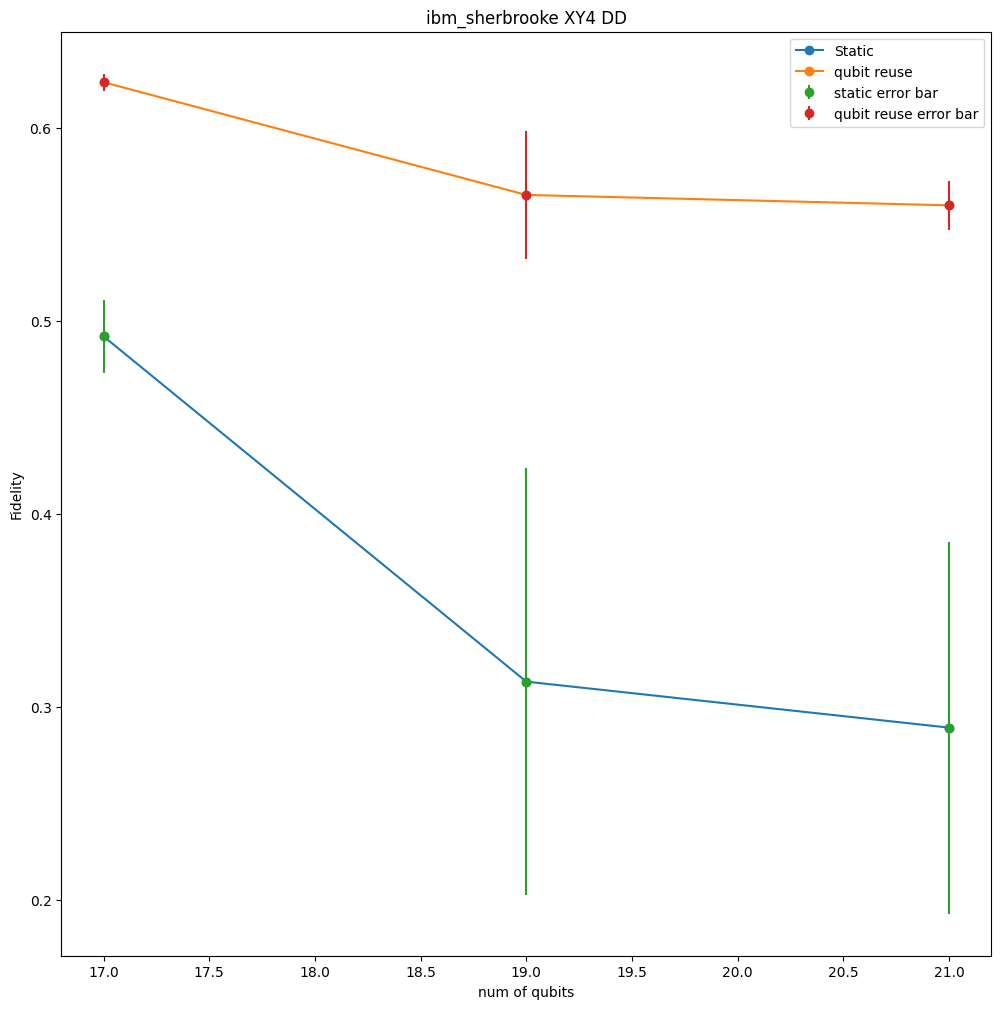

In [25]:
# Graph plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
#figure(figsize=(16,12), dpi=180)
fig, ax1 = plt.subplots(1, 1, figsize=(12,12))

# Create  data.
ax1.set_xlabel('num of qubits')
ax1.set_ylabel('Fidelity')
ax1.set_title('ibm_sherbrooke XY4 DD')

x1 = num_qubit_list
y1_static = Fidelity_mean_static_sherbrooke
#y1_dynamic_1 = Fidelity_mean_dynamic_1_sherbrooke
y1_dynamic_2 = Fidelity_mean_dynamic_2_sherbrooke
print(y1_static)
#print(y1_dynamic_1)
print(y1_dynamic_2)

y_error_static =Fidelity_std_static_sherbrooke
#y_error_dynamic_1 =Fidelity_std_dynamic_1_sherbrooke
y_error_dynamic_2 =Fidelity_std_dynamic_2_sherbrooke
print(y_error_static)
#print(y1_dynamic_1)
print(y_error_dynamic_2)

ax1.plot(x1, y1_static, 'o-',label='Static')
#ax1.plot(x1, y1_dynamic_1, 'o-',label='dynamic_1')
ax1.plot(x1, y1_dynamic_2, 'o-',label='qubit reuse')
ax1.errorbar(x1, y1_static,
			yerr = y_error_static, label='static error bar',
			fmt ='o')
#ax1.errorbar(x1, y1_dynamic_1,
			#yerr = y_error_dynamic_1, label='dynamic_1',
			#fmt ='o')
ax1.errorbar(x1, y1_dynamic_2,
			yerr = y_error_dynamic_2, label='qubit reuse error bar',
			fmt ='o')


plt.legend()
plt.show()

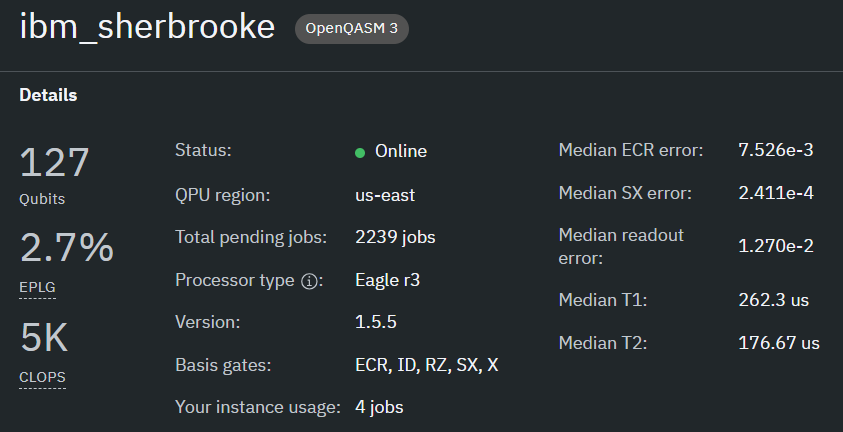

In [42]:
from IPython.display import Image, display
# Display the image
display(Image(filename="0_Sherbrooke 2024-08-02 110658.png"))


In [90]:
import json

with open("ghz_test.json") as f:
    y=json.load(f)
print(y)

{'Qubit number list:': [17, 19, 21], 'Circuit depth': {'qc_depth_static_list': [11, 12, 13], 'qc_depth_qubit_reuse_list': [46, 52, 58]}, 'Num_Qubits  in ideal AerSimulation': {'transpiled_static_num_qubits_list': [17, 19, 21], 'transpiled_qubit_reuse_num_qubits_list': [3, 3, 3]}, 'copies per instance:': 4, 'qasm_circuit_list:': {'qasm_static_circuit_list': ['OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q997[17];\ncreg cr2[17];\nh q997[8];\ncx q997[8],q997[9];\ncx q997[8],q997[7];\ncx q997[9],q997[10];\ncx q997[7],q997[6];\ncx q997[10],q997[11];\ncx q997[6],q997[5];\ncx q997[11],q997[12];\ncx q997[5],q997[4];\ncx q997[12],q997[13];\ncx q997[4],q997[3];\ncx q997[13],q997[14];\ncx q997[3],q997[2];\ncx q997[14],q997[15];\ncx q997[2],q997[1];\ncx q997[15],q997[16];\ncx q997[1],q997[0];\nmeasure q997[0] -> cr2[0];\nmeasure q997[1] -> cr2[1];\nmeasure q997[2] -> cr2[2];\nmeasure q997[3] -> cr2[3];\nmeasure q997[4] -> cr2[4];\nmeasure q997[5] -> cr2[5];\nmeasure q997[6] -> cr2[6];\nmeasure q997[

In [ ]:
"""
Baseline: 
Static circuit
Static circuit + DD
Qubit reuse (out-of-the-box plugin)
Circuit cutting (out-of-the-box)
Circuit cutting (out-of-the-box) + DD

Our approaches:
Qubit reuse (out-of-the-box plugin) + DD
Qubit reuse - selective qubit reset (SQR)
Qubit reuse (SQR) + DD
Qubit reuse (SQR) + Circuit cutting
Qubit reuse (SQR) + Circuit cutting + DD <- This should be the champion

Metrics:
Fidelity
Number of qubits used by the circuit
Circuit depth: 2-Qubit Depth

Circuit use-cases:
GHZ (let us start with this)
More cases to come...

Target platforms:
Simulation - to sanity check, debugging and start with this. We will not add it to the paper.
Real hardware - try 1 hardware consistently from Sherbrooke, Kyoto, Brisbane

Experiments:
Compare approaches to baselines for all the three metrics:
Data to store per experiment:
Hardware name used
Noise profile
Time of experiment
Job id
Number of qubits
Circuit  (input circuit used)
Output circuit(s) [after qubit reuse, circuit cutting etc]
Result data
sampler will give distribution - store this
All metrics - fidelity, number of qubits used, 2q-depth
Number of cuts used with circuit cutting
DD pulse
Which qubits were meant be reset for the all qubit reuse approaches (baseline and also our approaches)
Layouts used

3 plots per use-case
10 plot lines in plot
"""